In [8]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from MatrixVectorizer import MatrixVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score

from utils import vectorize_matrix

sns.set_theme(style="whitegrid")

In [9]:
# Path to your .csv files
lr_data_path_train = 'data/lr_train.csv'
lr_data_path_test = 'data/lr_test.csv'
hr_data_path = 'data/hr_train.csv'

# Load the data
df_lr_train = pd.read_csv(lr_data_path_train)
df_lr_test = pd.read_csv(lr_data_path_test)
df_lr = pd.concat([df_lr_train, df_lr_test], axis=0, ignore_index=True)
df_hr = pd.read_csv(hr_data_path)


In [10]:
print("LR Train DataFrame shape:", df_lr_train.shape)
print("LR Test DataFrame shape:", df_lr_test.shape)

LR Train DataFrame shape: (167, 12720)
LR Test DataFrame shape: (112, 12720)


In [11]:
lr_matrices = vectorize_matrix(df_lr, 160)
hr_matrices = vectorize_matrix(df_hr, 268)

### General Statistics

In [12]:
# Basic Data Checks
print("LR DataFrame shape:", df_lr.shape)
print("HR DataFrame shape:", df_hr.shape)
print("LR matrices shape:", lr_matrices[0].shape)
print("HR matrices shape:", hr_matrices[0].shape)

print("\nMissing values in LR:", df_lr.isna().sum().sum())
print("Missing values in HR:", df_hr.isna().sum().sum())

def calculate_statistics(data):
    statistics = {
        'Mean': np.mean(data),
        'Median': np.median(data),
        'Standard Deviation': np.std(data),
        'Min': np.min(data),
        'Max': np.max(data)
    }
    return statistics

# Calculate statistics for LR and HR data
lr_stats = calculate_statistics(df_lr.values)
hr_stats = calculate_statistics(df_hr.values)

# Create a DataFrame to hold the statistics for comparison
df_stats = pd.DataFrame({'LR Data': lr_stats, 'HR Data': hr_stats})

# Round the numbers to four decimal places for better readability
df_stats = df_stats.round(4)

print(df_stats)


LR DataFrame shape: (279, 12720)
HR DataFrame shape: (167, 35778)
LR matrices shape: (160, 160)
HR matrices shape: (268, 268)

Missing values in LR: 0
Missing values in HR: 0
                    LR Data  HR Data
Mean                 0.1960   0.2599
Median               0.1483   0.2338
Standard Deviation   0.2002   0.2231
Min                  0.0000   0.0000
Max                  0.9990   0.9999


In [15]:
# Correlation between LR and HR means
# Global Statistical Summaries
lr_means = df_lr.mean(axis=1)
hr_means = df_hr.mean(axis=1)

corr, p = pearsonr(lr_means[:len(hr_means)], hr_means)
print(f"Correlation between LR and HR means: {corr:.3f} (p={p:.3g})")

Correlation between LR and HR means: 0.902 (p=4.54e-62)



Is first LR matrix symmetric? True
Is first HR matrix symmetric? True

LR matrix diagonal (max): 1.0
HR matrix diagonal (max): 1.0

LR value range: [0.000, 1.000]
HR value range: [0.000, 1.000]


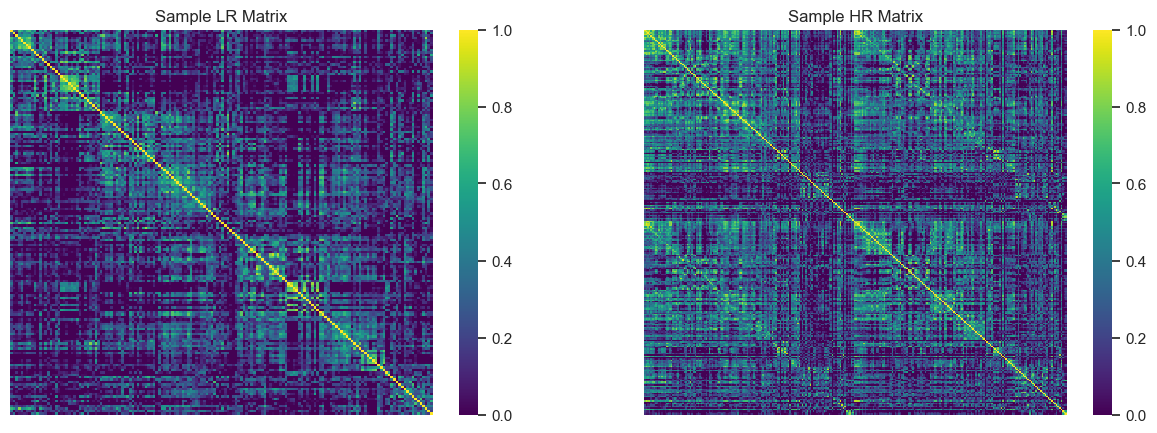

In [13]:
# Matrix Analysis
def is_symmetric(matrix):
    return np.allclose(matrix, matrix.T)

sample_lr = lr_matrices[0]
sample_hr = hr_matrices[0]
print("\nIs first LR matrix symmetric?", is_symmetric(sample_lr))
print("Is first HR matrix symmetric?", is_symmetric(sample_hr))
print("\nLR matrix diagonal (max):", np.max(np.diag(sample_lr)))
print("HR matrix diagonal (max):", np.max(np.diag(sample_hr)))
# Value Ranges
print(f"\nLR value range: [{np.min(lr_matrices):.3f}, {np.max(lr_matrices):.3f}]")
print(f"HR value range: [{np.min(hr_matrices):.3f}, {np.max(hr_matrices):.3f}]")


# Visualize Sample Matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(sample_lr, ax=axes[0], cmap='viridis', xticklabels=False, yticklabels=False)
axes[0].set_title('Sample LR Matrix')
sns.heatmap(sample_hr, ax=axes[1], cmap='viridis', xticklabels=False, yticklabels=False)
axes[1].set_title('Sample HR Matrix')
plt.show()

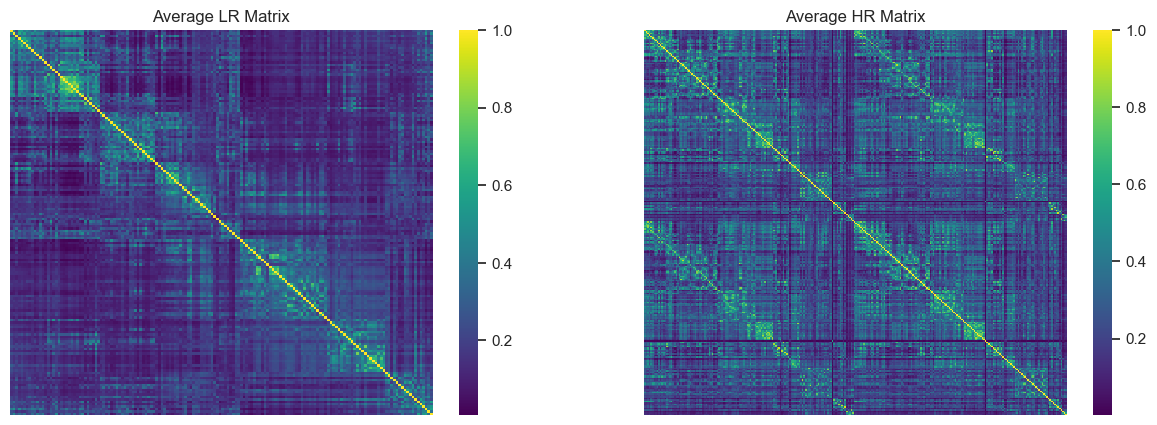

In [14]:
# Average Matrices
avg_lr = np.mean(lr_matrices, axis=0)
avg_hr = np.mean(hr_matrices, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(avg_lr, ax=axes[0], cmap='viridis', xticklabels=False, yticklabels=False)
axes[0].set_title('Average LR Matrix')
sns.heatmap(avg_hr, ax=axes[1], cmap='viridis', xticklabels=False, yticklabels=False)
axes[1].set_title('Average HR Matrix')
plt.show()

### Connectivity & Sparsity

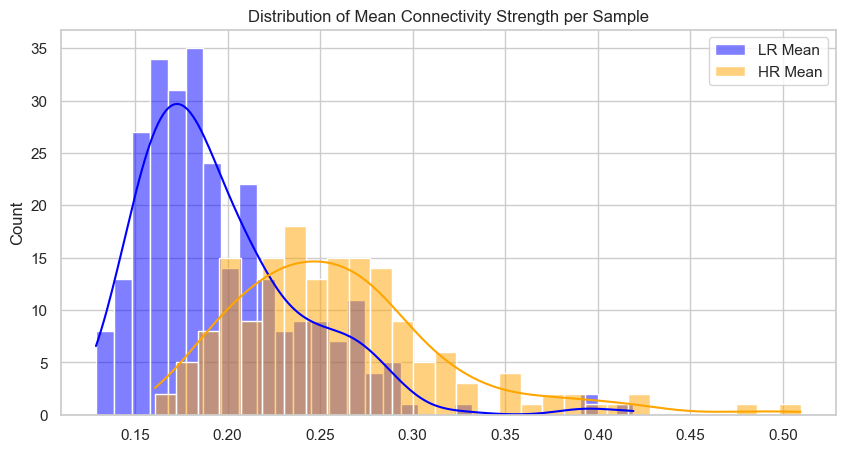

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(lr_means, bins=30, label='LR Mean', kde=True, color='blue')
sns.histplot(hr_means, bins=30, label='HR Mean', kde=True, color='orange')
plt.title('Distribution of Mean Connectivity Strength per Sample')
plt.legend()
plt.show()

In [17]:
# Distribution of Connectivity Strengths
def get_off_diagonal(matrix):
    n = matrix.shape[0]
    return matrix[np.triu_indices(n, k=1)]

sample_lr_flat = get_off_diagonal(sample_lr)
sample_hr_flat = get_off_diagonal(sample_hr)

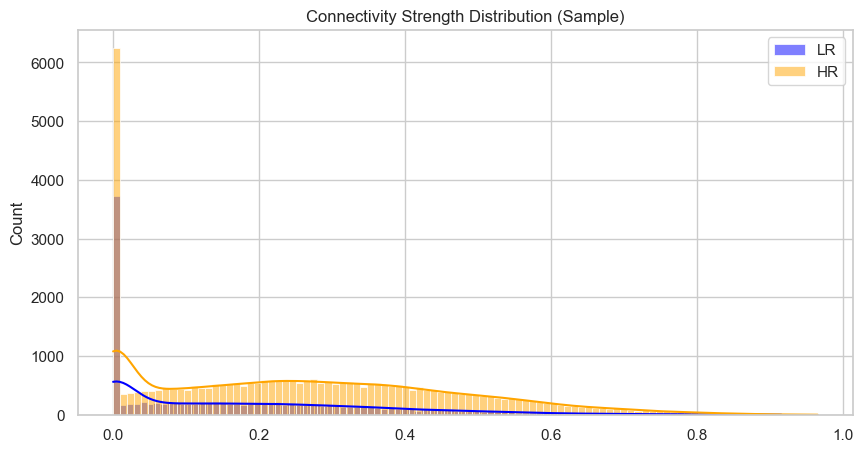

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(sample_lr_flat, label='LR', kde=True, color='blue', bins=100)
sns.histplot(sample_hr_flat, label='HR', kde=True, color='orange', bins=100)
plt.title('Connectivity Strength Distribution (Sample)')
plt.legend()
plt.show()

In [19]:
# Sparsity Analysis
# Treat anything below 0.05 as 0
threshold = 0.05
print(f"\nLR Sparsity (<{threshold} threshold): {np.mean(sample_lr_flat < threshold):.2%}")
print(f"HR Sparsity (<{threshold} threshold): {np.mean(sample_hr_flat < threshold):.2%}")


LR Sparsity (<0.05 threshold): 35.94%
HR Sparsity (<0.05 threshold): 21.93%


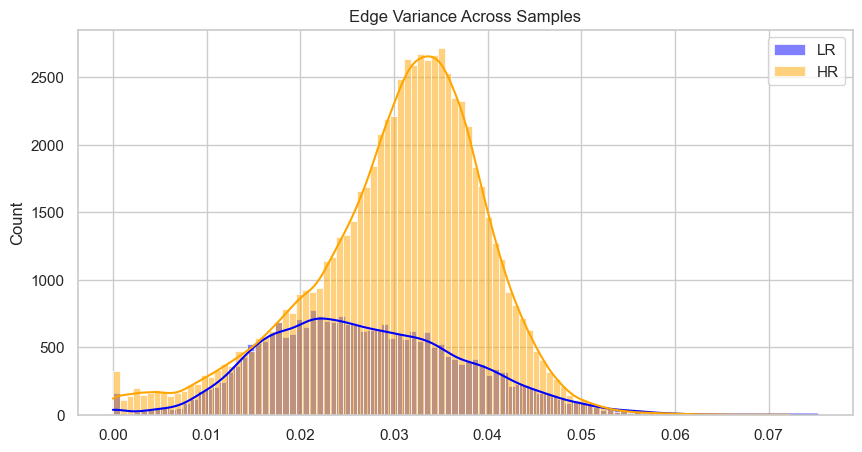

In [20]:
# Variance Analysis
var_lr = np.var(lr_matrices, axis=0)
var_hr = np.var(hr_matrices, axis=0)

plt.figure(figsize=(10, 5))
sns.histplot(var_lr.flatten(), label='LR', kde=True, color='blue', bins=100)
sns.histplot(var_hr.flatten(), label='HR', kde=True, color='orange', bins=100)
plt.title('Edge Variance Across Samples')
plt.legend()
plt.show()

### Node Degrees

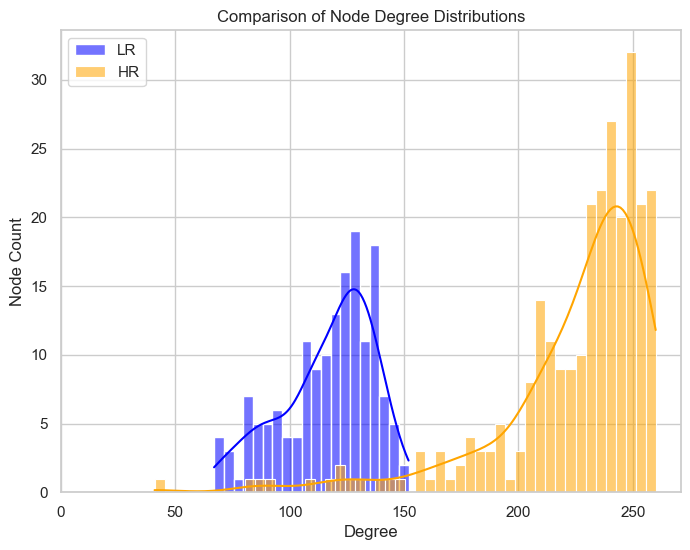

In [21]:
# Create graphs
G1 = nx.from_numpy_array(lr_matrices[0])
G2 = nx.from_numpy_array(hr_matrices[0])

# Compute degrees
degrees_G1 = [deg for _, deg in G1.degree()]
degrees_G2 = [deg for _, deg in G2.degree()]

# Plot distributions    
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)

sns.histplot(degrees_G1, alpha=0.55, color='blue', kde=True, label='LR', bins=20)
sns.histplot(degrees_G2, alpha=0.55, color='orange', kde=True, label='HR', bins=50)

plt.title("Comparison of Node Degree Distributions")
plt.xlabel("Degree")
plt.ylabel("Node Count")
plt.legend()
plt.grid(True)
plt.xlim(0,)
plt.ylim(0,)
plt.show()

### Graph Plots

In [22]:
def plot_graph(A, title):    
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(A)
    
    # Create the layout for the graph
    pos = nx.spring_layout(G, iterations=2000)
    
    # Draw nodes, edges, and labels
    plt.figure(figsize=(16, 12))
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', edgecolors='black', alpha=0.8, node_size=400)
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black', font_weight="bold")
    
    plt.title(f"{title} Graph Visualization")
    plt.axis("off")
    plt.show()


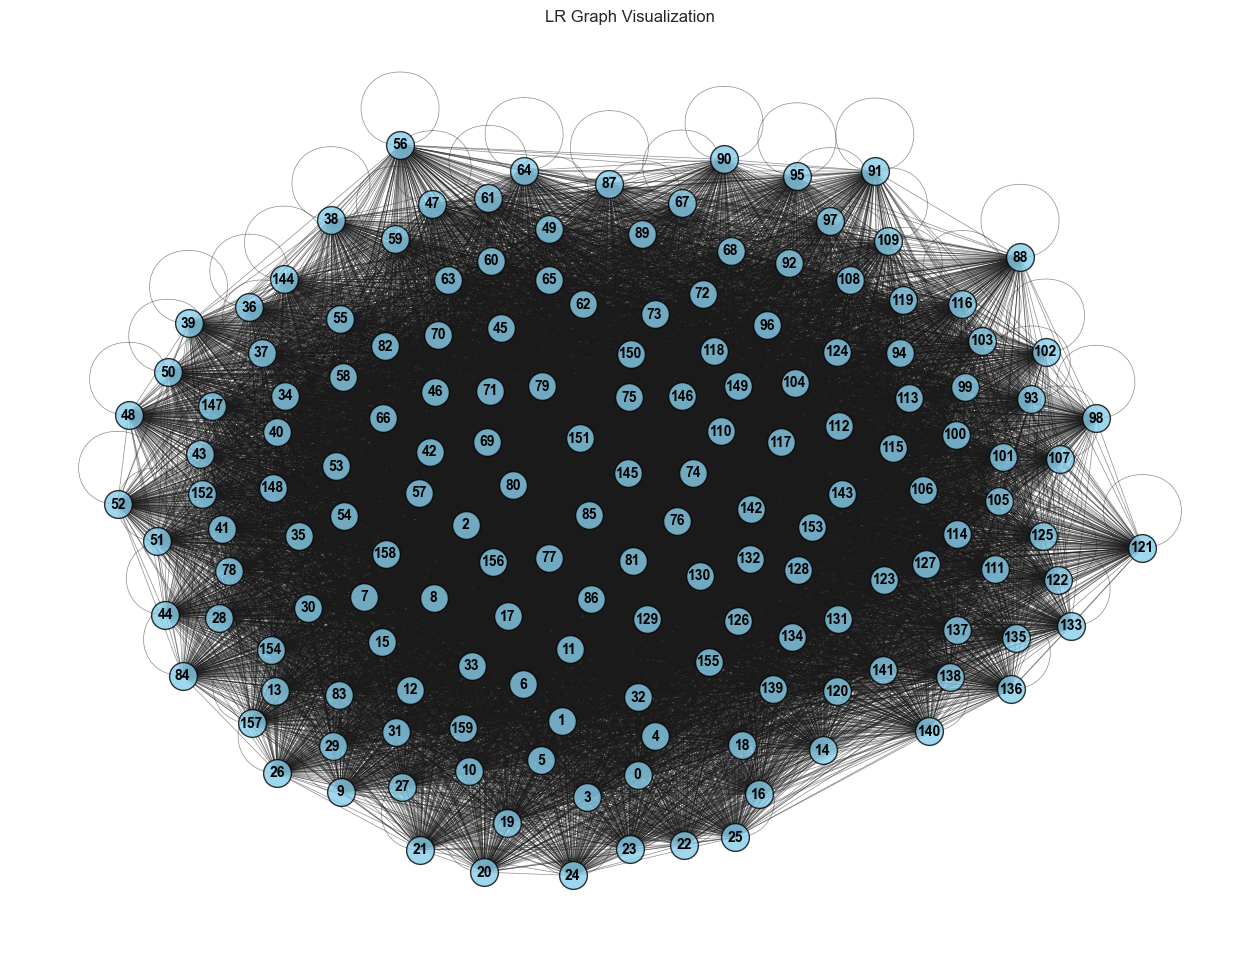

In [23]:
plot_graph(avg_lr, "LR")

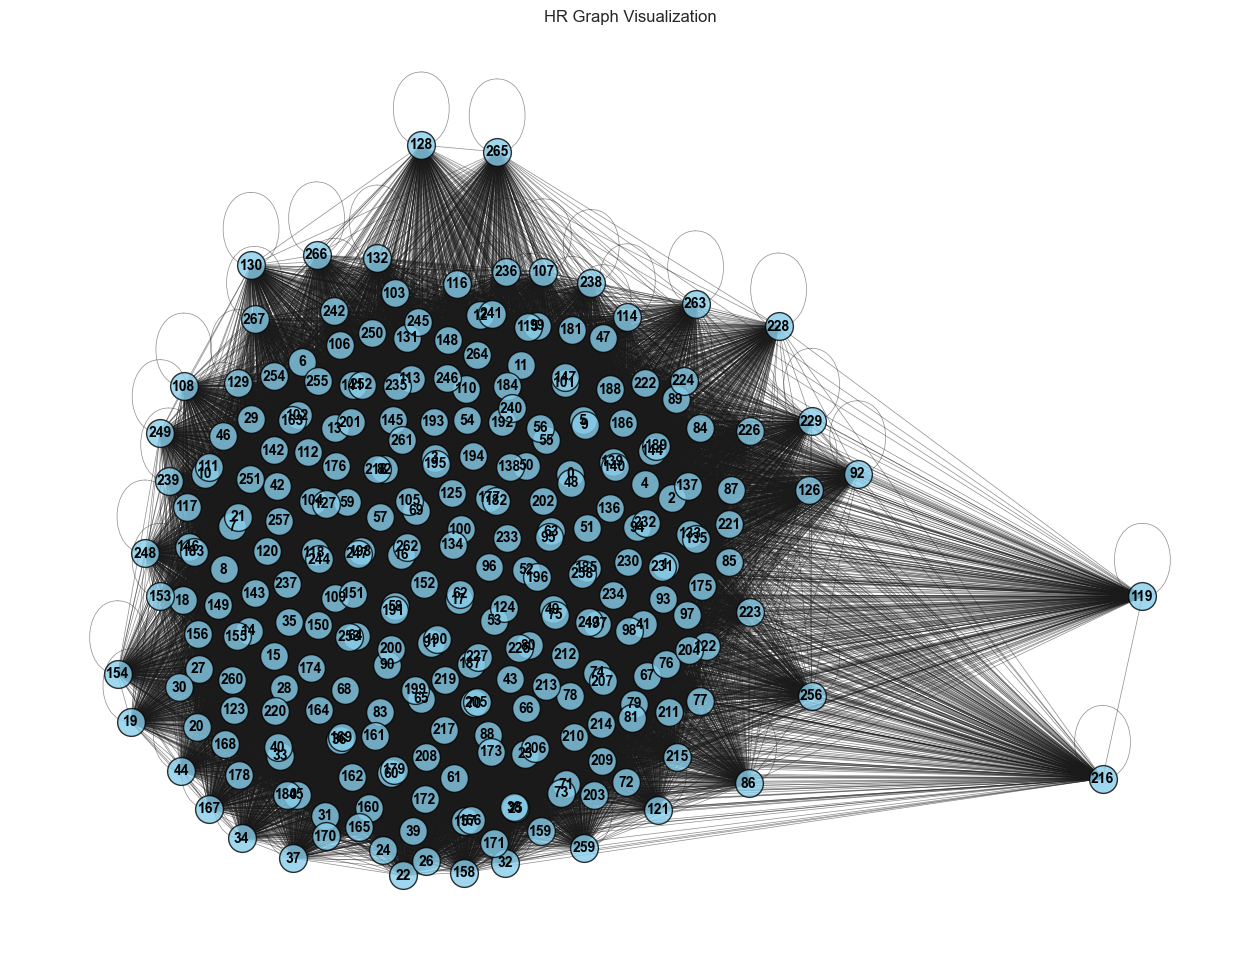

In [24]:
plot_graph(avg_hr, "HR")